In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

## Subsampling analysis

Examine how drivers predicted by CHASM2 change as a function of sample size.

#### Read in the data

In [2]:
# make the column names more informative
rename_dict = {
    'number signif mutations': 'Number of significant\nunique missense mutations',
    'avg mutations per sample': 'Driver prevalence\n(average mutations per patient)',
    'fraction': 'fraction of samples'
}

# read in each cancer type
cancer_types = ['acc', 'sarc', 'prad', 'thym', 'uvm', 'paad', 'brca', 'hnsc', 'coad']
df_list = []
for c in cancer_types:
    tmp = pd.read_table('CHASM2/data/subsample_with_rarity/{0}_subsample.txt'.format(c)).rename(columns=rename_dict)
    tmp['cancer type'] = c
    df_list.append(tmp)

# merge into single dataframe
df = pd.concat(df_list)

# label cancer types by cluster
cpal = sns.color_palette().as_hex()
cluster_1 = ['coad']
df.loc[df['cancer type'].isin(cluster_1), 'cluster'] = cpal[0]
cluster_2 = ['acc', 'sarc', 'prad']
df.loc[df['cancer type'].isin(cluster_2), 'cluster'] = cpal[1]
cluster_3 = ['thym']
df.loc[df['cancer type'].isin(cluster_3), 'cluster'] = cpal[2]
cluster_4 = ['brca', 'hnsc']
df.loc[df['cancer type'].isin(cluster_4), 'cluster'] = cpal[3]
cluster_5 = ['uvm', 'paad']
df.loc[df['cancer type'].isin(cluster_5), 'cluster'] = cpal[4]

In [45]:
# use custom scatter call to fix bug in seaborn
def scatter(x, y, c, **kwargs):
    plt.scatter(x, y, c=c, zorder=10)
    
# use custom scatter call to fix bug in seaborn
def lmplot(x, y, c, **kwargs):
    sns.lmplot(x, y, data=kwargs['data'], lowess=True)
    
def regplot(x, y, c, **kwargs):
    corr, pval = stats.pearsonr(x.dropna(), y.dropna())
    ax = sns.regplot(x, y, color=c.iloc[0])
    plt.text(.05, .9, 'R^2={0:.2g}; P={1:.2g}'.format(corr**2, pval), transform = ax.transAxes)

#### Number of significant mutations (Supplementary Figure 5)

Examine the number of unique mutations identified at a q-value threshold of 0.01.

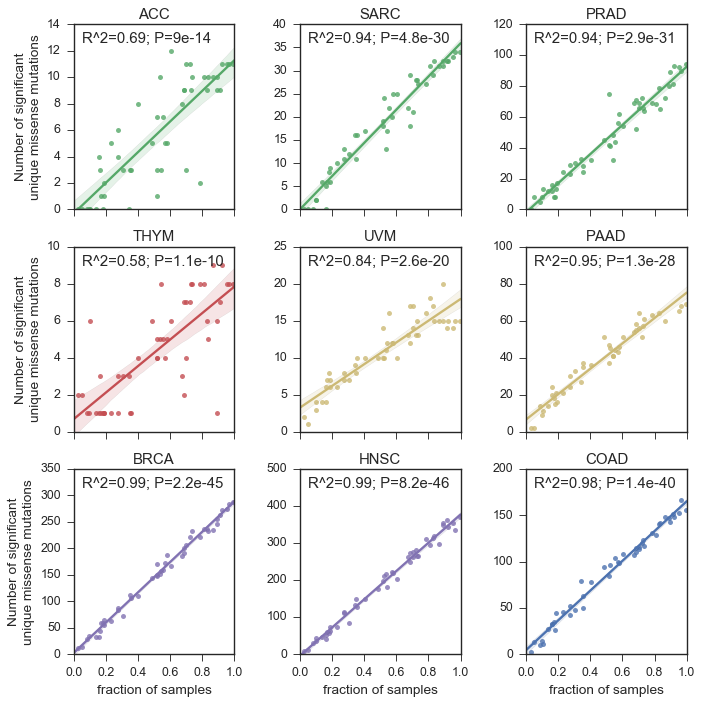

In [46]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    # plot data
    g = sns.FacetGrid(df, col="cancer type", margin_titles=True, col_wrap=3, xlim=(0, 1), sharey=False, despine=False)
    g.map(regplot, "fraction of samples", 'Number of significant\nunique missense mutations', 'cluster')
    
    # format axes and titles
    _ = [ax.set_ylim(bottom=0) for ax in g.axes]
    [ax.xaxis.set_ticks_position('bottom') for ax in g.axes]
    [ax.yaxis.set_ticks_position('left') for ax in g.axes]
    ctypes = df['cancer type'].str.upper().unique()
    [ax.set_title(ctypes[i]) for i, ax in enumerate(g.axes)]
    
    # save plot
    plt.savefig('CHASM2/figures/num_significant_subsample_v3.pdf')

#### Examine driver prevalence (Figure 4c)

Examine how prevalence of driver mutations per samples varies. This analysis will count a mutation more than once if it was observed in more than one sample.

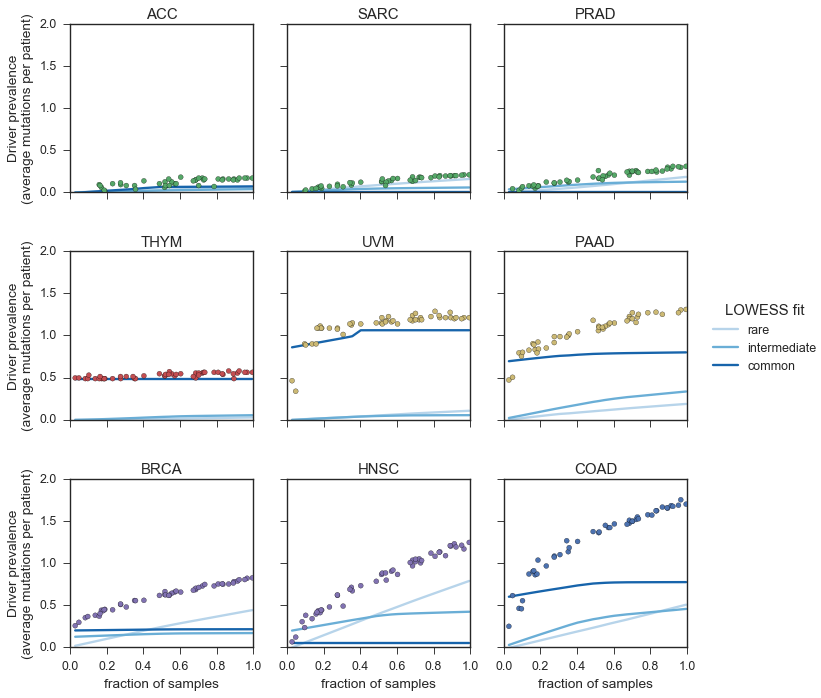

In [40]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    # plot data
    blues = sns.color_palette("Blues", 9).as_hex()
    g = sns.FacetGrid(df, col="cancer type", margin_titles=True, col_wrap=3, 
                      xlim=(0, 1), ylim=(0,2), sharey=True, despine=False, legend_out=True)
    g.map(sns.regplot, "fraction of samples", 'avg mutations per sample (rare)', scatter=False, lowess=True, color=blues[2], label='rare')
    g.map(sns.regplot, "fraction of samples", 'avg mutations per sample (intermediate)', scatter=False, lowess=True, color=blues[4], label='intermediate')
    g.map(sns.regplot, "fraction of samples", 'avg mutations per sample (common)', scatter=False, color=blues[7], lowess=True, label='common')
    g.map(scatter, "fraction of samples", 'Driver prevalence\n(average mutations per patient)', 'cluster')
    
    # format axes and title
    [ax.xaxis.set_ticks_position('bottom') for ax in g.axes]
    [ax.yaxis.set_ticks_position('left') for ax in g.axes]
    ctypes = df['cancer type'].str.upper().unique()
    [ax.set_title(ctypes[i]) for i, ax in enumerate(g.axes)]
    handles, labels = g.axes[0].get_legend_handles_labels()
    myleg = g.fig.legend(handles[:-1], labels[:-1], title='LOWESS fit', loc='center right', bbox_to_anchor=(1.15, .5))
    
    # save plot
    #plt.savefig('figures/driver_prevalence_subsample_v2.pdf', bbox_inches='tight', bbox_extra_artists=[myleg])